# First attempt on a classifier discriminating ttbar and ttW

We can't train on just SS because the rate is too low.

In [1]:
import uproot
import awkward
import numpy as np
import pandas as pd
from uproot_methods import TLorentzVectorArray

from coffea.processor import LazyDataFrame
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (typ

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_hdf('data/data_X.h5') # load data processed with ML_processor.py

sig_df = df[df['signal']==1]
bkg_df = df[df['signal']==0]

# usually we have less signal than background
nSmall = len(sig_df) if len(sig_df) < len(bkg_df) else len(bkg_df)

# Balance the signal and background sets
tmp_bkg_df = bkg_df.sample( n = nSmall )
tmp_sig_df = sig_df.sample( n = nSmall )

y_sig = np.ones(len(tmp_sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [tmp_sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

print ("The smaller data set contains %s events"%nSmall)

# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.9*y_tmp.shape[0] ), random_state=42 )

variables = ['mll', 'njet', 'nbtag', 'st', 'ht', 'met', 'mjj_max', 'mlb_min', 'mlb_max', 'l0_pt', 'l1_pt', 'deltaR_lj_min', 'j0_pt']
#variables = ['mll', 'st', 'ht', 'met', 'mjj_max', 'mlb_min', 'mlb_max', 'l0_pt', 'l1_pt', 'deltaR_lj_min', 'j0_pt']

X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]

The smaller data set contains 14837 events


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


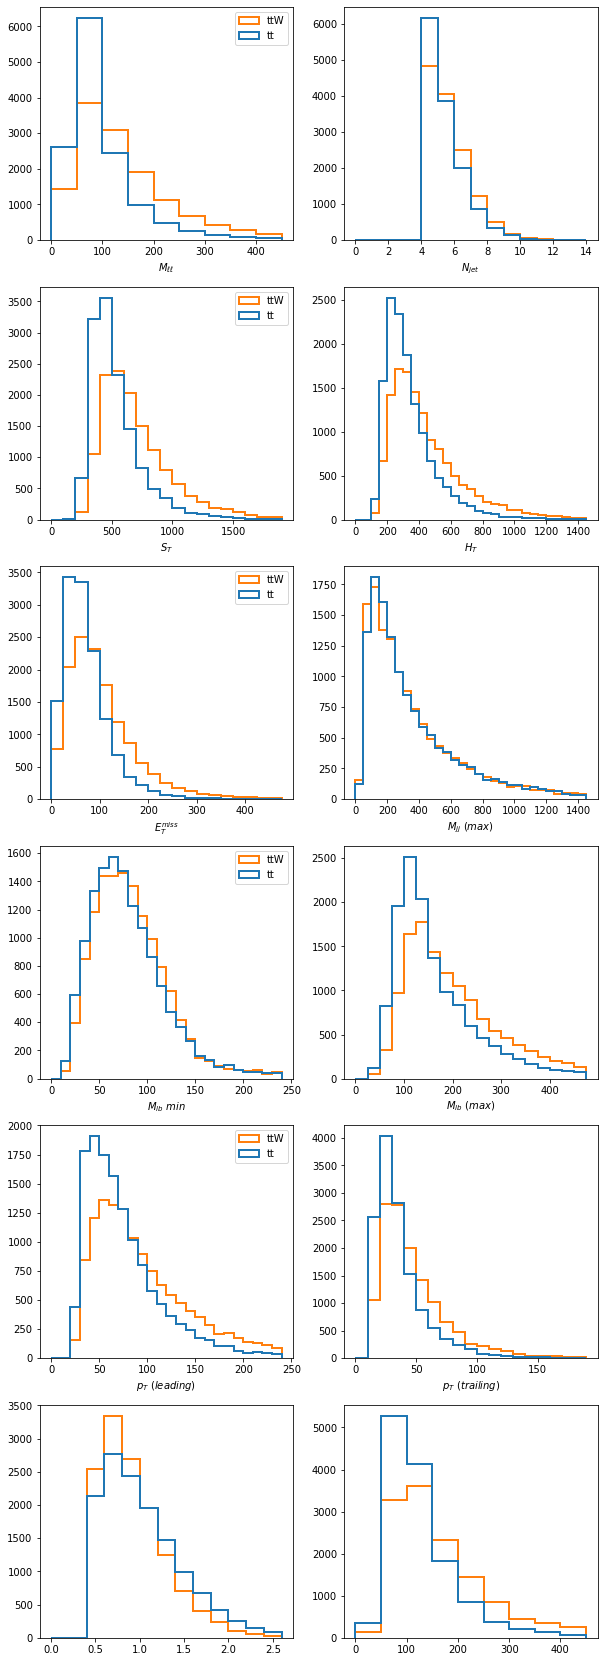

In [4]:
X_bkg = X_train[y_train==0]
X_sig = X_train[y_train==1]

fig, axs = plt.subplots(6,2, figsize=(10,30))

hist, bins, ax = axs[0,0].hist( [ X_bkg[['mll']].values, X_sig[['mll']].values ], range(0,500,50), histtype='step', linewidth=2, label=['tt', 'ttW'])
hist, bins, ax = axs[0,1].hist( [ X_bkg[['njet']].values, X_sig[['njet']].values ], range(0,15,1), histtype='step', linewidth=2) 
hist, bins, ax = axs[1,0].hist( [ X_bkg[['st']].values, X_sig[['st']].values ], range(0,2000,100), histtype='step', linewidth=2, label=['tt', 'ttW'])
hist, bins, ax = axs[1,1].hist( [ X_bkg[['ht']].values, X_sig[['ht']].values ], range(0,1500,50), histtype='step', linewidth=2) 
hist, bins, ax = axs[2,0].hist( [ X_bkg[['met']].values, X_sig[['met']].values ], range(0,500,25), histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[2,1].hist( [ X_bkg[['mjj_max']].values, X_sig[['mjj_max']].values ], range(0,1500,50), histtype='step', linewidth=2) 
hist, bins, ax = axs[3,0].hist( [ X_bkg[['mlb_min']].values, X_sig[['mlb_min']].values ], range(0,250,10), histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[3,1].hist( [ X_bkg[['mlb_max']].values, X_sig[['mlb_max']].values ], range(0,500,25), histtype='step', linewidth=2) 
hist, bins, ax = axs[4,0].hist( [ X_bkg[['l0_pt']].values, X_sig[['l0_pt']].values ], range(0,250,10), histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[4,1].hist( [ X_bkg[['l1_pt']].values, X_sig[['l1_pt']].values ], range(0,200,10), histtype='step', linewidth=2) 
hist, bins, ax = axs[5,0].hist( [ X_bkg[['deltaR_lj_min']].values, X_sig[['deltaR_lj_min']].values ], [0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6], histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[5,1].hist( [ X_bkg[['j0_pt']].values, X_sig[['j0_pt']].values ], range(0,500,50), histtype='step', linewidth=2) 

axs[0,0].set_xlabel(r'$M_{\ell\ell}$')
axs[0,1].set_xlabel(r'$N_{jet}$')
axs[1,0].set_xlabel(r'$S_{T}$')
axs[1,1].set_xlabel(r'$H_{T}$')
axs[2,0].set_xlabel(r'$E_{T}^{miss}$')
axs[2,1].set_xlabel(r'$M_{jj}~(max)$')
axs[3,0].set_xlabel(r'$M_{lb}~{min}$')
axs[3,1].set_xlabel(r'$M_{lb}~(max)$')
axs[4,0].set_xlabel(r'$p_{T}~(leading)$')
axs[4,1].set_xlabel(r'$p_{T}~(trailing)$')

axs[0,0].legend()
axs[1,0].legend()
axs[2,0].legend()
axs[3,0].legend()
axs[4,0].legend()

In [5]:
# Normalize Data - mean to 0, and std to 1 
X_mean, X_std = X_train.mean(), X_train.std()

X_train -= X_mean
X_train /= X_std

X_test -= X_mean
X_test /= X_std

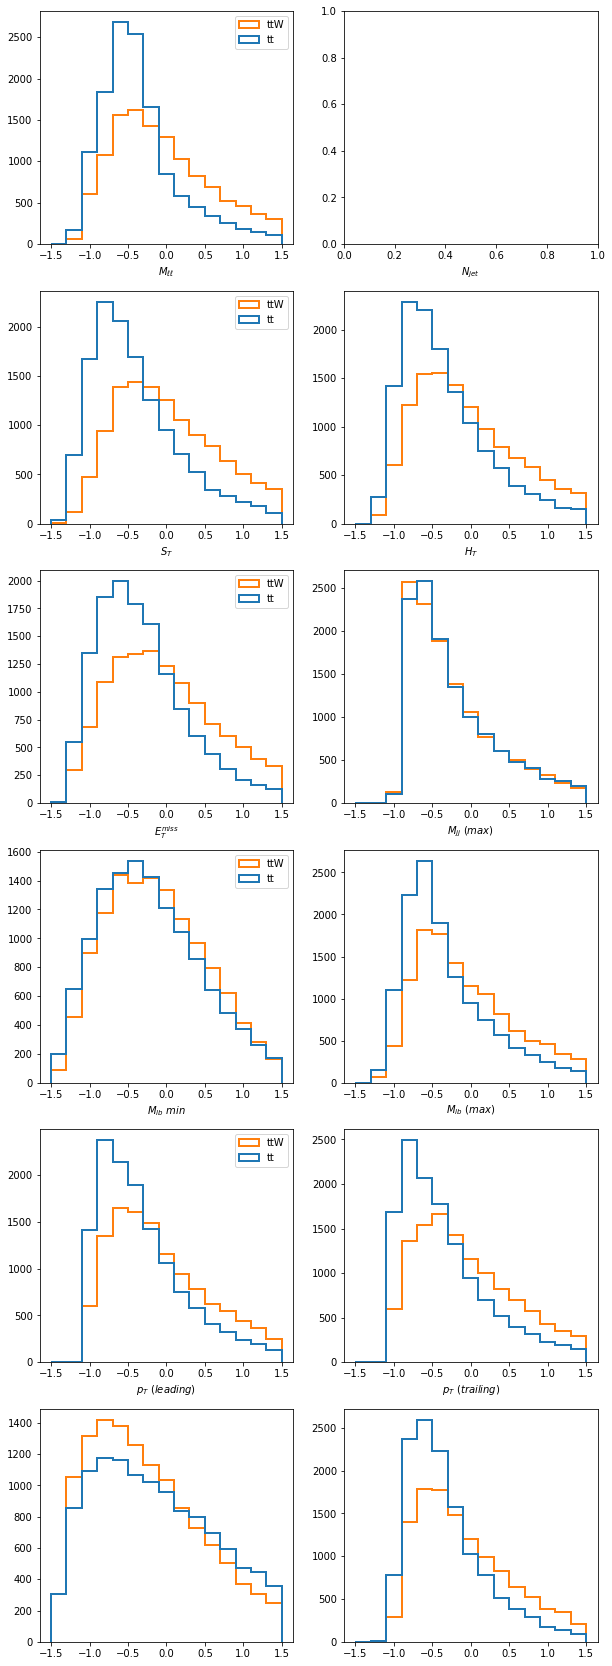

In [6]:
X_bkg = X_train[y_train==0]
X_sig = X_train[y_train==1]

fig, axs = plt.subplots(6,2, figsize=(10,30))

binning = [-1.5,-1.3,-1.1,-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5]

hist, bins, ax = axs[0,0].hist( [ X_bkg[['mll']].values, X_sig[['mll']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW'])
#hist, bins, ax = axs[0,1].hist( [ X_bkg[['njet']].values, X_sig[['njet']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[1,0].hist( [ X_bkg[['st']].values, X_sig[['st']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW'])
hist, bins, ax = axs[1,1].hist( [ X_bkg[['ht']].values, X_sig[['ht']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[2,0].hist( [ X_bkg[['met']].values, X_sig[['met']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[2,1].hist( [ X_bkg[['mjj_max']].values, X_sig[['mjj_max']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[3,0].hist( [ X_bkg[['mlb_min']].values, X_sig[['mlb_min']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[3,1].hist( [ X_bkg[['mlb_max']].values, X_sig[['mlb_max']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[4,0].hist( [ X_bkg[['l0_pt']].values, X_sig[['l0_pt']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[4,1].hist( [ X_bkg[['l1_pt']].values, X_sig[['l1_pt']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[5,0].hist( [ X_bkg[['deltaR_lj_min']].values, X_sig[['deltaR_lj_min']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[5,1].hist( [ X_bkg[['j0_pt']].values, X_sig[['j0_pt']].values ], binning, histtype='step', linewidth=2) 

axs[0,0].set_xlabel(r'$M_{\ell\ell}$')
axs[0,1].set_xlabel(r'$N_{jet}$')
axs[1,0].set_xlabel(r'$S_{T}$')
axs[1,1].set_xlabel(r'$H_{T}$')
axs[2,0].set_xlabel(r'$E_{T}^{miss}$')
axs[2,1].set_xlabel(r'$M_{jj}~(max)$')
axs[3,0].set_xlabel(r'$M_{lb}~{min}$')
axs[3,1].set_xlabel(r'$M_{lb}~(max)$')
axs[4,0].set_xlabel(r'$p_{T}~(leading)$')
axs[4,1].set_xlabel(r'$p_{T}~(trailing)$')

axs[0,0].legend()
axs[1,0].legend()
axs[2,0].legend()
axs[3,0].legend()
axs[4,0].legend()

In [20]:
epochs = 300
batch_size = 5120
validation_split = 0.2

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Dense(units=8, activation='relu', input_dim=X_train.shape[1], ))
model.add( tf.keras.layers.Dense(units=32, activation='relu' ) )
model.add( tf.keras.layers.Dropout( rate = 0.1 ) )
model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8)                 112       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                288       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [21]:
from ML.lrcurve import KerasLearningCurve

history = model.fit(X_train.values, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0, callbacks=[KerasLearningCurve()])
model.save( 'data/training.h5', include_optimizer=False )

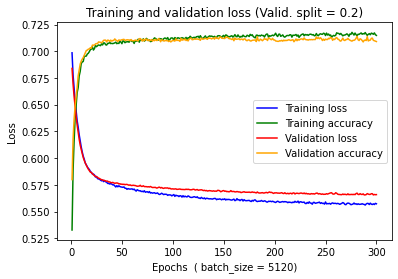

In [9]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)

plt.plot(epochslist, loss_values, 'b', label='Training loss')
plt.plot(epochslist, acc_values,'b', color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'b', color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'b', color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

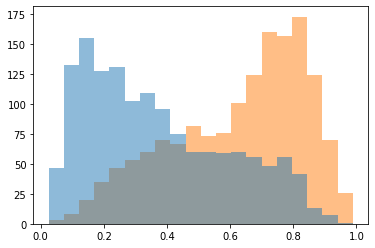

In [22]:
loaded_model = tf.keras.models.load_model('../ML/data/training.h5', custom_objects=None, compile=False)

# use the model to predict whether an event is signal or background
y_test_pred = pd.DataFrame( loaded_model.predict( X_test.values  ) , index = X_test.index)

xbin = 20
hist, bins, ax = plt.hist( [ y_test_pred[y_test==0].values, y_test_pred[y_test==1].values ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

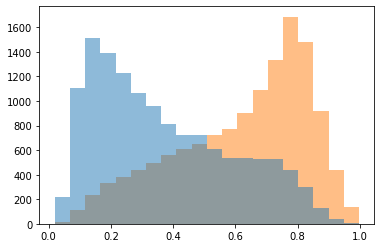

In [23]:
# use the model to predict whether an event is signal or background. this is with the training set
y_train_pred = pd.DataFrame( loaded_model.predict( X_train.values  ) , index = X_train.index)

xbin = 20
hist, bins, ax = plt.hist( [ y_train_pred[y_train==0].values, y_train_pred[y_train==1].values ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

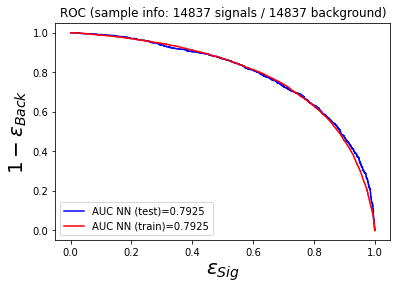

In [24]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN (test)=' + str(round(auc_val_test,4) ))


fpr_train, tpr_train, thresholds_test = roc_curve( y_train, y_train_pred )
auc_val_train = auc(fpr_test, tpr_test)

plt.plot( tpr_train, 1-fpr_train, 'r', label= 'AUC NN (train)=' + str(round(auc_val_train,4) ))


plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')


In [13]:
means = pd.DataFrame(X_mean)
with open('data/means.json', 'w') as f:
    f.write(means.to_json())

# load the data frame and convert it to a series with squeeze
means = pd.read_json('data/means.json').squeeze()

stds = pd.DataFrame(X_std)
with open('data/stds.json', 'w') as f:
    f.write(stds.to_json())

# load the data frame and convert it to a series with squeeze
stds = pd.read_json('data/stds.json').squeeze()

In [14]:
X_train.values

array([[-0.08199878, -0.06412856,  1.13163846, ...,  0.87416869,
        -0.88598272,  0.1708287 ],
       [ 0.8386649 ,  2.38713654,  1.13163846, ...,  1.66536641,
        -0.29937412, -0.86508012],
       [-0.61014825, -0.06412856, -0.70654271, ..., -0.78876901,
         0.2780531 , -0.75407994],
       ...,
       [-0.78767758, -0.88121692,  1.13163846, ..., -0.80004293,
        -1.23374105, -0.37830085],
       [-0.26700381, -0.06412856, -0.70654271, ...,  1.95959473,
         0.48573676, -0.37494567],
       [-0.73775133, -0.06412856, -0.70654271, ..., -0.67003262,
        -0.46586057, -0.33244684]])

In [15]:
y_train_pred = pd.DataFrame( model.predict( X_train.values  ) , index = X_train.index)

In [16]:
model_l = tf.keras.models.load_model('data/training.h5a')
model.predict( X_train.values  )

array([[0.6590895 ],
       [0.71979105],
       [0.27556482],
       ...,
       [0.54032475],
       [0.32531884],
       [0.23863614]], dtype=float32)

In [33]:
import pickle
#with  as f:
pickle.dump(X_train, open('test.pkl', "wb"))

In [38]:
pickle.load(open('test.pkl', 'rb'))

,mll,njet,nbtag,st,ht,met,mjj_max,mlb_min,mlb_max,l0_pt,l1_pt,deltaR_lj_min,j0_pt
14229,-0.081999,-0.064129,1.131638,-0.122670,-0.104442,-0.207488,-0.459923,-0.332499,0.106143,-0.354784,0.874169,-0.885983,0.170829
122,0.838665,2.387137,1.131638,-0.212905,-0.351657,-0.522098,-0.621545,-0.728703,-0.379641,0.127442,1.665366,-0.299374,-0.865080
131,-0.610148,-0.064129,-0.706543,-0.637193,-0.602176,0.363223,-0.708209,-0.795325,-1.064589,-0.862088,-0.788769,0.278053,-0.754080
96,0.785888,-0.881217,-0.706543,0.556390,0.034070,1.601596,-0.318119,-0.033206,0.161700,0.179734,1.304766,-0.521110,-0.151268
33621,-0.782625,0.752960,1.131638,-0.647790,-0.292934,-0.573340,-0.225634,-0.871543,-0.849199,-1.039541,-0.747482,-0.183373,-0.530961
61,-0.132028,-0.064129,-0.706543,-0.124961,0.221116,-0.547127,0.689039,-0.750906,0.981895,-0.530404,-0.629605,-0.361163,0.254708
7215,0.220866,-0.881217,-0.706543,0.460696,0.359834,-1.174588,-0.316719,0.950168,-0.344058,2.170660,-0.021753,-0.712863,0.182013
23,-0.402015,-0.881217,-0.706543,-0.481200,-0.682998,0.096921,-0.675283,-1.379485,-0.304208,0.544469,-0.949518,-1.126814,-0.648951
33417,-0.903185,-0.881217,-0.706543,1.673460,1.899160,0.517027,1.736974,-0.054661,-0.792491,-0.163684,1.231985,0.732498,1.739930
19,-0.894613,-0.064129,-0.706543,-0.943748,-0.866051,-0.033517,1.363409,-0.950055,-0.955250,-0.899717,-0.809190,-0.333837,-0.830690


In [29]:
file

NameError: name 'file' is not defined